### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns

from textwrap import wrap

from pathlib import Path

import pandas as pd

### Experiments data

In [4]:
components_dictionary = {'experiment_1': ['Pinene', 'Benzyl_benzoate'],
                        'experiment_2': ['Pinene', 'Limonene'],
                        'experiment_3': ['Benzyl_benzoate', 'm Anisaldehyde'],
                        'experiment_4': ['Isopropyl_myristate', 'Benzyl_benzoate', 'Alpha_pinene', 'Limonene'],
                        'experiment_5': ['Pinene', 'Benzyl_benzoate'],
                        'experiment_6': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_7': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_8': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Benzyl_benzoate', 'm Anisaldehyde']}

In [5]:
protons_dictionary = {'experiment_1': [16, 12],
                        'experiment_2': [16, 16],
                        'experiment_3': [12, 8],
                        'experiment_4': [34, 12, 16, 16],
                        'experiment_5': [16, 12],
                        'experiment_6': [4, 4, 5, 5, 13],
                        'experiment_7': [4, 4, 5, 5, 13],
                        'experiment_8': [4, 4, 5, 5, 13],
                        'experiment_9': [12, 8]}

In [6]:
ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                    'experiment_2': [0.505, 0.495],
                                    'experiment_3': [0.8403875207510383, 0.1596124792489616],
                                    'experiment_4': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                    'experiment_5': [0.3865, 0.6135],
                                    'experiment_6': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_7': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_8': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_9': [0.3702, 0.6298]}

In [7]:
cwd = Path(os.getcwd())
path = cwd.parent.absolute()

In [8]:
experiments_folders = [name for name in os.listdir(path)
                    if os.path.isdir(os.path.join(path, name)) and str(name).startswith('experiment')]

### Improving heatmaps

In [9]:
experiments_folders

['experiment_1_intensity_difference',
 'experiment_5_miniperfumes',
 'experiment_6_metabolites',
 'experiment_3_overlapping_and_intensity_difference',
 'experiment_7_and_8_shim',
 'experiment_9_different_solvents',
 'experiment_4_perfumes_and_absent_components',
 'experiment_2_overlapping']

In [10]:
experiments_folders = {'experiment_1': 'experiment_1_intensity_difference',
                        'experiment_5': 'experiment_5_miniperfumes',
                        'experiment_6': 'experiment_6_metabolites',
                         'experiment_3': 'experiment_3_overlapping_and_intensity_difference',
                         'experiment_7': 'experiment_7_and_8_shim',
                       'experiment_8': 'experiment_7_and_8_shim',
                        'experiment_9': 'experiment_9_different_solvents',
                        'experiment_4': 'experiment_4_perfumes_and_absent_components',
                         'experiment_2': 'experiment_2_overlapping'}

In [11]:
nr_of_experiment = 9

In [12]:
with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)

In [13]:
molar_proportions = ground_truth_molar_proportions['experiment_'+str(nr_of_experiment)]
protons = protons_dictionary['experiment_'+str(nr_of_experiment)]

In [14]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [15]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [16]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

In [17]:
with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)

In [18]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]

In [19]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [20]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

In [21]:
all_components_results_both = (all_components_results_vis + all_components_results_molar)/2

In [22]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [23]:
all_components_results_both.min().min()

0.002486096307815988

<IPython.core.display.Javascript object>


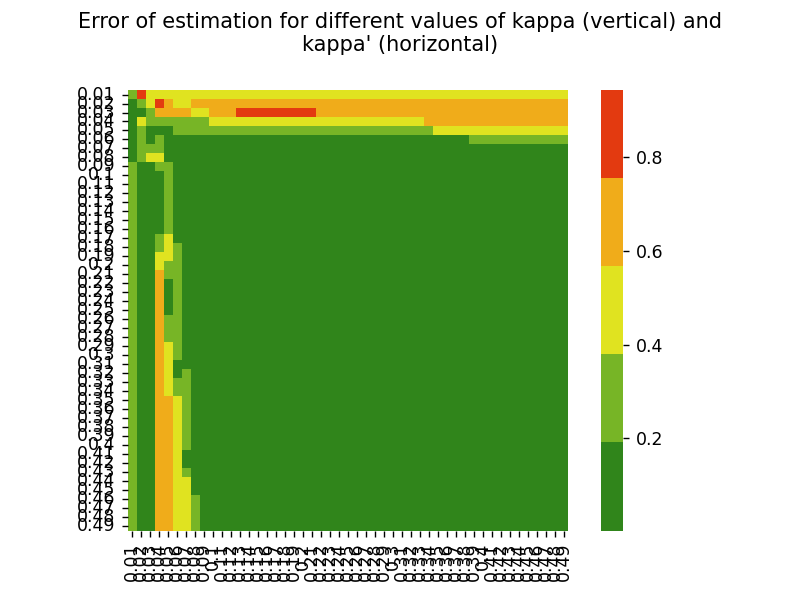

In [24]:
vmin = all_components_results_both.min().min()
vmax = all_components_results_both.max().max()

labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]
#cbar_ax = plt.add_axes([.91, .3, .03, .4])

colors = ["#30851b", "#77b526", "#e0e320", "#f0ac1a", "#e33a10"]

sns.heatmap(all_components_results_both.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette(colors), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
plt.tight_layout(rect=[0, 0, .9, 1])

In [25]:
all_components_results_both.shape

(49, 49)

In [26]:
rows_to_cut_beginning = 0
rows_to_cut_end = 49

In [27]:
kernel_size = 10

In [28]:
import numpy as np
import skimage.measure

a = np.array(all_components_results_both.iloc[rows_to_cut_beginning:rows_to_cut_end, 
                                              rows_to_cut_beginning:rows_to_cut_end])
res = skimage.measure.block_reduce(a, (kernel_size, kernel_size), np.mean)

In [29]:
a.shape

(49, 49)

In [30]:
res.shape

(5, 5)

In [31]:
#

<IPython.core.display.Javascript object>


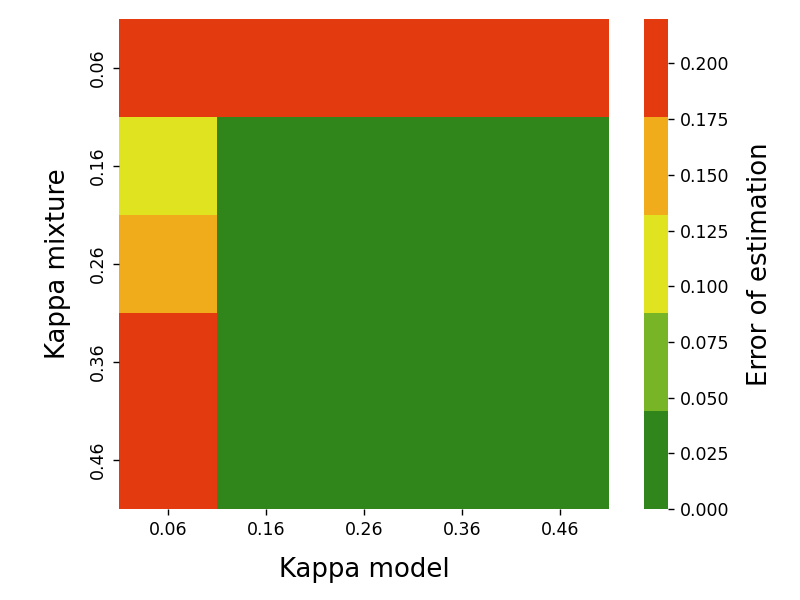

In [32]:
vmin = 0
vmax = 0.22

colors = ["#30851b", "#77b526", "#e0e320", "#f0ac1a", "#e33a10"]
# Set your custom color palette
#cmap = sns.set_palette(sns.color_palette(colors))

labels = [round(x,3) for x in dataframes_ready_for_heatmap[0].iloc[rows_to_cut_beginning:rows_to_cut_end,
                                                                   rows_to_cut_beginning:rows_to_cut_end]][int(np.ceil(kernel_size/2))::kernel_size]
#cbar_ax = plt.add_axes([.91, .3, .03, .4])

ax = sns.heatmap(res.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette(colors),
           cbar_kws={'label': 'Error of estimation'})
ax.figure.axes[-1].yaxis.label.set_size(15)

cbar = ax.collections[0].colorbar
cbar.set_label('Error of estimation', labelpad=10)

#plt.suptitle('\n'.join(wrap("Error of estimation for different values of parameters")), fontsize =12)

plt.xlabel("Kappa model", fontsize=15, labelpad=10)
plt.ylabel("Kappa mixture", fontsize=15, labelpad=10)
plt.show()
#fig.tight_layout()
plt.tight_layout()
plt.savefig('averaged_heatmap_experiment_'+str(nr_of_experiment)+'.png', dpi=300)